# Modern Decision Making: Applied Machine Learning
# Webinar: Unsupervised Learning.


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.family'] = 'DejaVu Sans'


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Filled Colors
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    # Contour line
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    # Calculate -log densities
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),   # normalize using log normal
                 levels=np.logspace(0, 2, 12))        # 12 levels
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])   # get cluster
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

## Load data and explore it

**Why:** we need to explore the data.

**Takeaway:** we see that our data does not have any labels, and it has very high number of features -- 561. In this case, we cannot visualize it efficiently, so we need to think how we can reduce dimensionality to get some insights

In [ ]:
X = pd.read_csv('X_train.zip', compression='zip')

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288584,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929293,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.999918,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943067,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.999867,-0.991134,-1.0,-0.841270,0.532060,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993978,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337201,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.999845,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736522,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996092,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,0.682401,0.837869,-0.986093,-0.999976,-0.999736,-0.999504,-0.997180,-0.983799,-0.986007,-0.627446,-0.850930,-0.911872,0.061436,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,-0.170813,0.294938,-0.306081,0.482148,-0.470129,-0.305693,-0.362654,0.507459,...,-0.999895,-0.988055,-1.0,1.000000,0.678921,-0.701131,-0.909639,-0.989413,-0.987836,-0.986850,-0.986749,-0.996199,-0.989413,-0.999876,-0.989136,-0.720891,-1.000000,-0.035684,-0.230091,-0.511217,-0.995221,-0.995237,-0.995722,-0.995273,-0.995732,-0.995221,-0.999974,-0.995226,-0.955696,-0.936508,0.404573,-0.117290,-0.482844,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,-0.824705,0.849095,0.683250,0.837869,-0.992653,-0.999991,-0.999856,-0.999757,-0.998004,-0.981232,-0.991325,-0.786553,-0.559477,-0.761434,0.313276,-0.131208,0.191161,0.086904,0.257615,-0.272505,0.434728,-0.315375,0.439744,-0.269069,0.179414,-0.088952,-0.155804,-0.189763,0.599213,...,-0.999941,-0.994169,-1.0,-1.000000,0.559058,-0.528901,-0.858933,-0.991433,-0.989059,-0.987744,-0.991462,-0.998353,-0.991433,-0.999902,-0.989321,-0.763372,-0.897436,-0.273582,-0.510282,-0.830702,-

In [ ]:
y = np.loadtxt('samsung_train_labels.txt').astype(int)

X = X.values

In [ ]:
X.shape

(7352, 561)

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

**Why:** we need to explore the data.

**Takeaway:** again, here we tried to do a scatterplot, and it doesn't look very insightful. Soon we will see how to use PCA for dimensionality reduction.

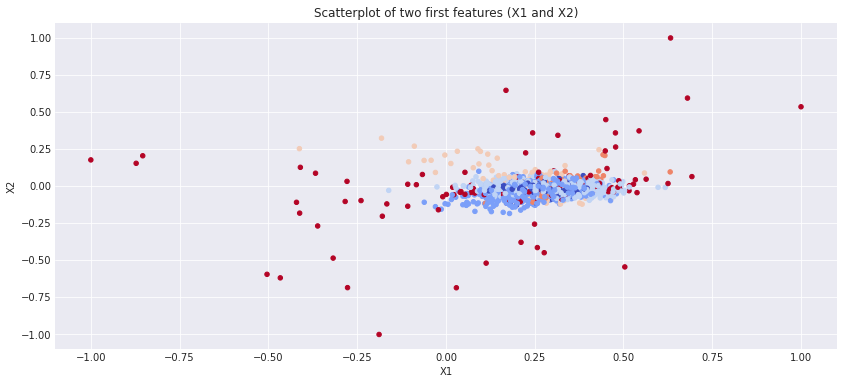

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Scatterplot of two first features (X1 and X2)')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

## Dimensionality Reduction with Principal Component Analysis (PCA)


#### Projection

- In most real-world problems, training instances are not spread out uniformly across all dimensions.
- Many features are almost constant, while others are highly correlated. As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.


- PCA identifies the axis that accounts for the largest amount of variance in the training set.
- It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of *remaining variance*.
- In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and so on.
- The unit vector that defines the ith axis is called the *ith principal component* (PC).
- There is a standard matrix factorization technique called **Singular Value Decomposition** (SVD) that can decomposes the (centered) training set matrix $\mathbf X$ into the matrix multiplication of three matrices $\mathbf U \mathbf\Sigma \mathbf V^T$, where $\mathbf V$ contains all the principal components that we are looking for.

$$\mathbf X = \mathbf U \mathbf\Sigma \mathbf V^T$$

where:
- $\mathbf U$ and $\mathbf V$ are $m\times p$ and $p\times p$ **orthogonal matrices**, with the columns of $\mathbf U$ spanning the column space of $\mathbf X$, and the columns of $\mathbf V$ spanning the row space.
- $\mathbf \Sigma$ is a $p\times p$ diagonal matrix, with diagonal entries $s_1\geq s_2\geq\ldots\geq s_p\geq 0$ called the **singular values** of $\mathbf X$.

- The sample covariance matrix is given by $\mathbf S=\mathbf X^T\mathbf X/m$. We then have

$$\mathbf X^T\mathbf X= \mathbf V \mathbf \Sigma^2 \mathbf V^T$$,

- Thus, we see that the *principal components* $v_j$ (columns of $\mathbf V$) are the eigenvectors of $\mathbf X^T\mathbf X$.
- The first principal component has the property that $\mathbf z_1=\mathbf X v_1=\mathbf u_1 s_1$ has the largest sample variance amongst the normalized linear combinations of the columns of $\mathbf X$:

$$\mathrm{Var}(\mathbf z_1)= \mathrm{Var}(\mathbf u_1 s_1)=\frac{s_1^2}{m}$$

- Subsequent PCs ($z_j$) have maximum variance $\frac{s_j^2}{m}$, subject to being orthogonal to the earlier ones.
- Finally, the last PC ($z_p$) has minimum variance.

### Applying PCA to data

**Why:** Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.

While many algorithms (such as SVM, K-nearest neighbors, and logistic regression) require features to be normalized, intuitively we can think of Principle Component Analysis (PCA) as being a prime example of when normalization is important. In PCA we are interested in the components that maximize the variance. If one component (e.g. human height) varies less than another (e.g. weight) because of their respective scales (meters vs. kilos), PCA might determine that the direction of maximal variance more closely corresponds with the ‘weight’ axis, if those features are not scaled. As a change in height of one meter can be considered much more important than the change in weight of one kilogram, this is clearly incorrect.

**Takeaway:** Scale the sample using `StandardScaler` with default parameters.



In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [ ]:
X_pca.shape, X.shape

((7352, 561), (7352, 561))

### Visualizing results

**Why:** Here we compare two scatterplots -- one with raw features, and another with two first principal components -- to see the difference

**Takeaway:** Projection of 561's dimensional space on two first PCs looks more insightful!



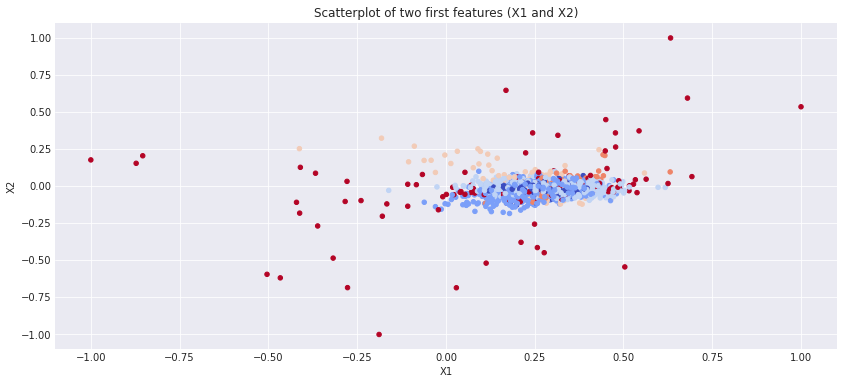

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Scatterplot of two first features (X1 and X2)')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

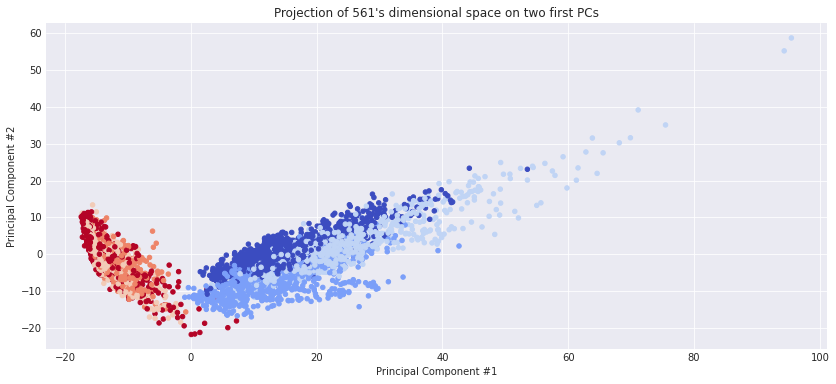

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='coolwarm')

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

### Choosing the number of components

**Why:** We want to choose the appropriate number of components, and for it we can look at variance explained by each principal component. We can make a plot of explained variance vs the number of components and explore it

**Takeaway:**
- we can see that a single first component explains more than 50% of variation in data
- the second PC explains ~7%, and each next PC explains less and less


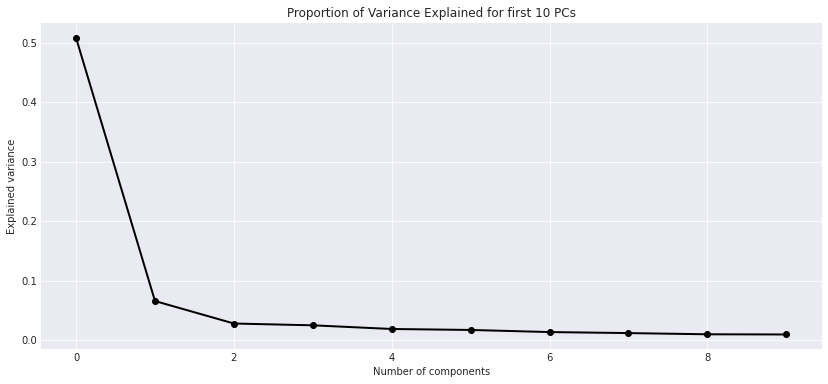

In [ ]:
k = 10

plt.figure(figsize=(14, 6))
plt.plot(pca.explained_variance_ratio_[:k], color='k', marker='o', lw=2)

plt.title('Proportion of Variance Explained for first {} PCs'.format(k))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

plt.show()

**Why:** To make the graph even more visual and insightful, we can make a plot of **cummulative** explained variance vs the number of components

**Takeaway:**
- we can see that if we want to keep 90% of variance explained, we need only ~65 components
- this will give us a huge reduction in data size


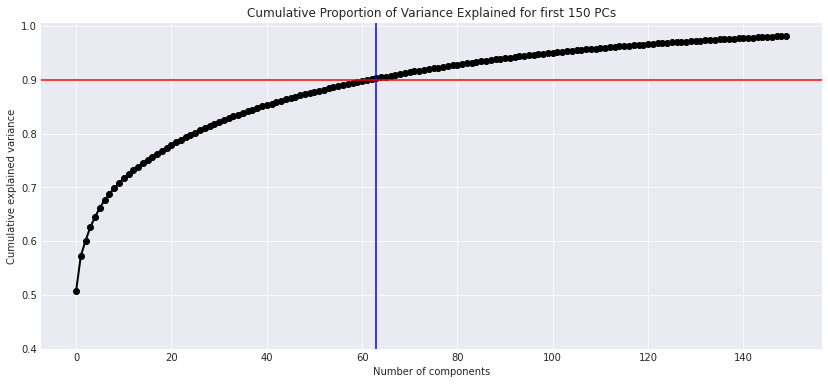

In [ ]:
k = 150

plt.figure(figsize=(14, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_[:k]), color='k', marker='o', lw=2)

plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.axvline(63, c='b')
plt.axhline(0.9, c='r')

plt.title('Cumulative Proportion of Variance Explained for first {} PCs'.format(k))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

plt.show()

**Question:**
What is the minimum number of principal components required to cover the 75% of the variance of the original (scaled) data?

In [ ]:
pca = PCA(n_components=0.75, random_state=42)

X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(7352, 16)

**Question:**
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [ ]:
pca.explained_variance_ratio_[0:2]

array([0.50781172, 0.0658068 ])

## Clustering

Both clustering and PCA seek to simplify the data via a small number
of summaries, but their mechanisms are different:
- PCA looks to find a low-dimensional representation of the observations
that explain a good fraction of the variance;
- Clustering looks to find homogeneous subgroups among the observations.

**Note**: For clustering we will work with only 2 components for better visualization

In [ ]:
X_two_dim = X_pca[:, :2]

idx = (X_two_dim[:,0] < 50) & (X_two_dim[:,1] < 15)

X_two_dim = X_two_dim #[idx,:]

### k-Means

K-means clustering is a simple and elegant approach for partitioning a data set into $K$ distinct, non-overlapping clusters. To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the $K$ clusters.


We begin by defining some notation. Let $C_1, ..., C_K$ denote sets containing the indices of the observations in each cluster. These sets satisfy two properties:
1. Each observation belongs to at least one of the K clusters.
2. The clusters are nonoverlapping: no observation belongs to more than one cluster.


The idea behind K-means clustering is that a good clustering is one for which the within-cluster variation is as small as possible. The within-cluster variation for cluster $C_k$ is a measure $W(C_k)$ of the amount by which the observations
within a cluster differ from each other. Hence we want to solve the problem $$\sum_{k=1}^K W(C_k) \to \min_{C_k}.$$ In words, this formula says that we want to partition the observations into $K$ clusters such that the total within-cluster variation, summed over all $K$ clusters, is as small as possible.

In order to make it actionable we need to define the within-cluster variation. There are many possible ways to define this concept, but by far the most common choice involves squared Euclidean distance. That is, we define $$W(C_k) = \frac{1}{|C_k|}\sum_{i,i'\in C_k}\sum_{j=1}^p\left(x_{ij}-x_{i'j}\right)^2.$$ In other words, the within-cluster variation for the kth cluster is the sum of all of the pairwise squared Euclidean distances between the observations in the k-th cluster, divided by the total number of observations in the k-th cluster.

In [ ]:
kmeans = KMeans(n_clusters=4)

kmeans.fit(X_two_dim)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**Why:** We want to check, what clusters we obtained from using k-means

**Takeaway:**
- we can see that if we use k-means with two clusters, we get very meaningful result
- however for $k>2$ clusters are not very meaningful -- it's because of the structure of our data (there are clearly 2 clusters) and the way k-means works


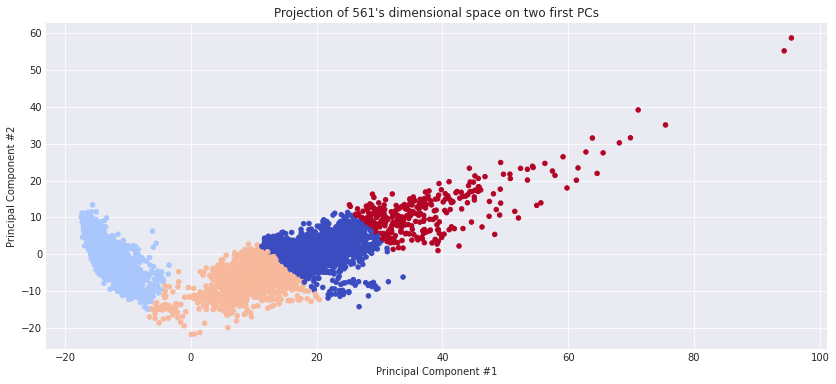

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:,0], X_two_dim[:,1], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

**Why:** We want to check, how k-means works

**Takeaway:** we see centroids (centers of each cluster) and "decision boundaries" -- hyperplanes that separate clusters

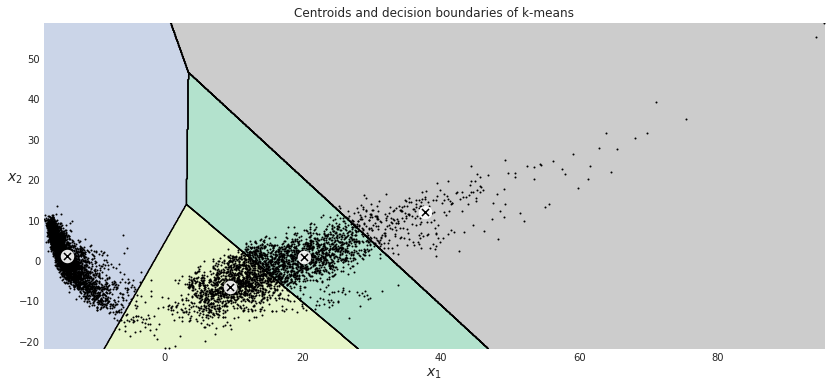

In [ ]:
plt.figure(figsize=(14, 6))
plot_decision_boundaries(kmeans, X_two_dim)

plt.title('Centroids and decision boundaries of k-means')

plt.show()

**Takeaway:**
- we can also use fitted kmeans object to make predictions for new observations
- and to transform data to cluster-distance space


In [ ]:
X_two_dim[:1,:]

array([[-16.13854357,   2.15202398]])

In [ ]:
kmeans.predict(X_two_dim[:1,:])

array([1], dtype=int32)

In [ ]:
a = kmeans.transform(X_two_dim[:1,:])

print(a)

[[36.32061317  2.21929004 26.98679613 54.65154846]]



**Why:** We want to choose the number of clusters $k$, because we cannot always visualize our dataset (it can have more than 2 dimensions etc.)

**Takeaway:**
- We can use the elbow method to select the optimal number of clusters
- We will use inertia: it is the sum of squared distances of samples to their closest cluster center.

In [ ]:
k_max = 10

inertia = []
for k in range(1, k_max):

    kmeans = KMeans(n_clusters=k).fit(X_two_dim)

    inertia.append(np.sqrt(kmeans.inertia_))

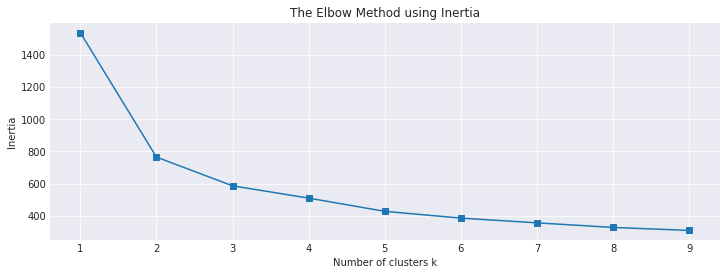

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

**Question:**
How many clusters can we choose according to the elbow method?

In [ ]:
d = {}
for k in range(2, k_max-1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

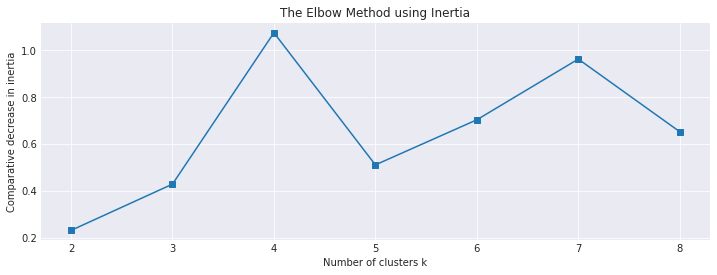

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max-1), [x for x in d.values()], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

To determine the optimal number of clusters, we have to select the value of $k$ at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 4.

### Agglomerative clustering

One potential disadvantage of K-means clustering is that it requires us to pre-specify the number of clusters K. Hierarchical clustering is an alternative approach which does not require that we commit to a particular choice of K. Hierarchical clustering has an added advantage over K-means clustering in that it results in an attractive tree-based representation of the observations, called a dendrogram.

In [ ]:
idx = np.random.randint(X_two_dim.shape[0], size=5000)

X_two_dim_sample = X_two_dim[idx,:]

In [ ]:
ag = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')

ag.fit(X_two_dim_sample)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6)

**Why:** We want to check, what clusters we obtained from using Agglomerative Clustering

**Takeaway:**
- we can see that if we use Agglomerative Clustering with two clusters, we get very meaningful result
- however for $k>2$ clusters are not very meaningful -- it's because of the structure of our data (there are clearly 2 clusters)

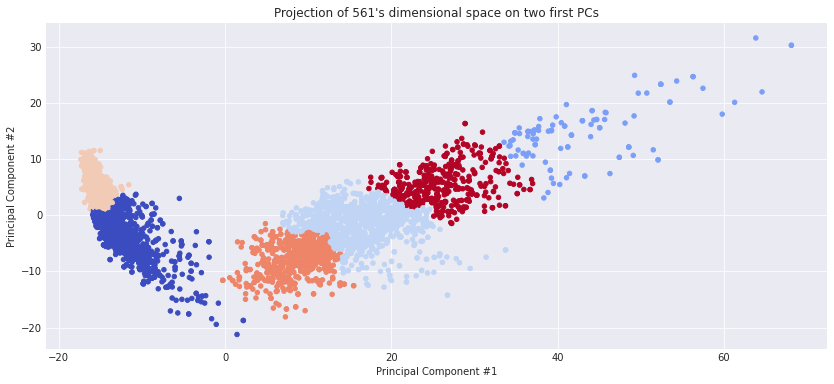

In [ ]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim_sample[:,0], X_two_dim_sample[:,1], c=ag.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 561\'s dimensional space on two first PCs')
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')

plt.show()

**Why:** We want to understand, how Agglomerative Clustering works. We can do it by plotting dendogram

**Takeaway:**
- Visual inspection can often be useful for understanding the structure of the data, though more so in the case of small sample sizes

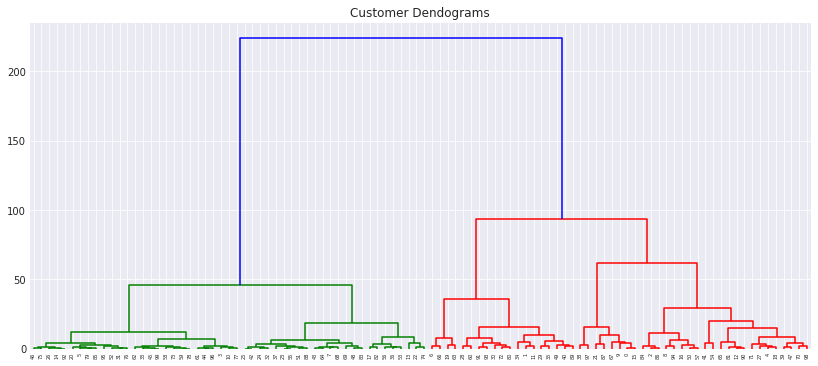

In [ ]:
import scipy.cluster.hierarchy as shc

idx = np.random.randint(X_two_dim.shape[0], size=100)

X_two_dim_sample = X_two_dim[idx,:]

plt.figure(figsize=(14, 6))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X_two_dim_sample, method='ward'))